In [69]:
import random
import numpy as np
import time
from scipy import sparse
import random
from importlib import reload
from recapi import recommender as rec

In [70]:
# Load the books dataset
import csv
incidence_file = '../data/csv/BX-Book-Ratings.csv'
user_item_rating_triples = list()
with open(incidence_file, encoding='latin1') as f:
    r = csv.reader(f, delimiter=';', skipinitialspace=True, quoting=csv.QUOTE_ALL)
    next(r)
    for row in r:
        if row[2] != '0' and row[2] < '5':
            continue
        user_item_rating_triples.append((row[0], row[1], 1))

In [ ]:
# movielens dataset
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')
user_item_rating_triples = [(u, i, 1) for u, i, r, t in data.raw_ratings if int(t) > 1]

In [67]:
reload(rec)
%time rmdr = rec.build_recommender_from_triples(\
    user_item_rating_triples, min_item_freq=5, min_user_freq=3)

print('%d items left' % len(rmdr.items))
print('%d users left' % len(rmdr.users))

original counts: 96735 users, 319762 items
construction took 1.09 secs
CPU times: user 3.5 s, sys: 64 ms, total: 3.57 s
Wall time: 3.57 s
40337 items left
22622 users left


In [72]:
reload(rec)
seed = random.randint(0,1000)
eval_str = 'relative rank mean %.4f, median %.4f, std %.3f'

seed = 15
alpha = 2.5
beta = 0.1

stats = lambda ser: (np.mean(ser), np.percentile(ser, 50), np.std(ser))
samples = 200

%time ranks = rec.ranking_stat(rmdr, samples, seed, alpha=alpha, no_mat=False, no_bias=True)
print(eval_str % stats(ranks))

%time ranks = rec.ranking_stat(rmdr, samples, seed, alpha=alpha, beta=beta, no_mat=False, no_bias=False)
print(eval_str % stats(ranks))

%time ranks = rec.ranking_stat(rmdr, samples, seed, no_mat=True, no_bias=False)
print(eval_str % stats(ranks))

CPU times: user 10.9 s, sys: 4 ms, total: 11 s
Wall time: 11 s
relative rank mean 0.1693, median 0.0566, std 0.233
CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s
relative rank mean 0.1661, median 0.0593, std 0.228
CPU times: user 7.62 s, sys: 0 ns, total: 7.62 s
Wall time: 7.62 s
relative rank mean 0.2725, median 0.1484, std 0.285


In [3]:
reload(rec)

eval_stat = dict()
eval_ranks = dict()

def register(params, typ, ranks):
    print(eval_str % (np.mean(ranks), np.std(ranks), params))
    key = tuple(params + [typ])
    eval_stat[key] = (np.mean(ranks), np.std(ranks))
    eval_ranks[key] = ranks
    
seed = random.randint(0,1000)
eval_str = 'mean relative rank %.4f, std %.3f for params %s'

seed = 15
samples = 2000

rmdr = rec.build_recommender_from_triples(
    user_item_rating_triples, min_item_freq=5, min_user_freq=2)

start = time.time()

ranks = rec.ranking_stat(rmdr, samples, seed, no_mat=True, no_bias=False)
register([None, None], 'nomat', ranks)

for alpha in 3 * 1.2 ** np.arange(-4, 5):
    ranks = rec.ranking_stat(rmdr, samples, seed, alpha=alpha, no_mat=False, no_bias=True)
    register(['%3.2f' % alpha, None], 'nobias', ranks)

    for beta in 0.05 * 2. ** np.arange(-4, 5):
        params = ['%3.1f' % alpha, '%4.3f' % beta]

        ranks = rec.ranking_stat(rmdr, samples, seed, alpha=alpha, beta=beta, no_mat=False, no_bias=False)
        register(['%3.2f' % alpha, '%4.3f' % beta], 'normal', ranks)
print('took {:.2f} seconds per parameter set'.format((time.time()-start) / len(eval_stat)))

import pickle
with open('./eval-seed15-muf2-mif5-samples2k.pickle', 'wb') as f:
    pickle.dump((eval_stat, eval_ranks), f)

original counts: 96735 users, 319762 items
construction took 1.05 secs
mean relative rank 0.2447, std 0.267 for params [None, None]
mean relative rank 0.1679, std 0.230 for params ['1.45', None]
mean relative rank 0.1638, std 0.223 for params ['1.45', '0.003']
mean relative rank 0.1638, std 0.223 for params ['1.45', '0.006']
mean relative rank 0.1638, std 0.223 for params ['1.45', '0.013']
mean relative rank 0.1637, std 0.223 for params ['1.45', '0.025']
mean relative rank 0.1637, std 0.223 for params ['1.45', '0.050']
mean relative rank 0.1638, std 0.223 for params ['1.45', '0.100']
mean relative rank 0.1638, std 0.223 for params ['1.45', '0.200']
mean relative rank 0.1637, std 0.223 for params ['1.45', '0.400']
mean relative rank 0.1636, std 0.223 for params ['1.45', '0.800']
mean relative rank 0.1661, std 0.230 for params ['1.74', None]
mean relative rank 0.1620, std 0.223 for params ['1.74', '0.003']
mean relative rank 0.1619, std 0.223 for params ['1.74', '0.006']
mean relative ra

params ('2.50', '0.100', 'normal'): median 0.054
params ('2.50', '0.100', 'normal'): mean 0.160
params (None, None, 'nomat'): median 0.136
params (None, None, 'nomat'): mean 0.245


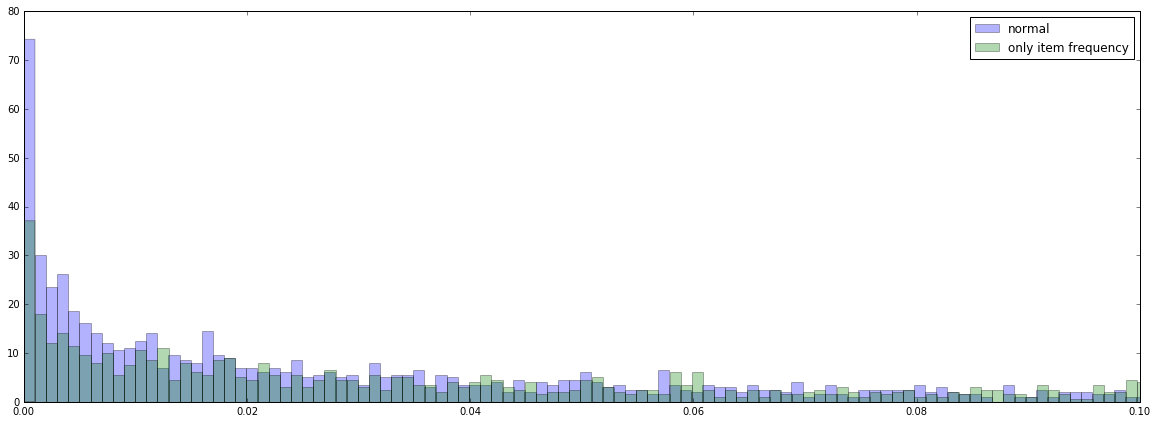

In [56]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import pickle
with open('./eval-seed15-muf2-mif5-samples2k.pickle', 'rb') as f:
    eval_stat, eval_ranks = pickle.load(f)

params = [('2.50', '0.100', 'normal'), (None, None, 'nomat')]
ranks = [eval_ranks[param] for param in params]

for i in range(2):
    print('params %s: median %4.3f' % (params[i], np.percentile(ranks[i], 50)))
    print('params %s: mean %4.3f' % (params[i], np.mean(ranks[i])))

    plt.figure(figsize=(20,7))
bins=1000
plt.hist(ranks[0], bins, normed=1, alpha=0.3, label='normal')
plt.hist(ranks[1], bins, normed=1, alpha=0.3, label='only item frequency')
# plt.hist(eval_ranks[('2.50', None, 'nobias')], bins, normed=1, alpha=0.3, label='no bias')

x1,x2,y1,y2 = plt.axis()
plt.axis((0,0.1,y1,y2))
plt.legend()
plt.show()

In [55]:
for k, v in sorted(eval_ranks.items(), key=lambda x: np.mean(x[1])):
    print(k, 'mean %6.4f, std %4.2f, q50, %5.4f, q25 %5.4f' % (np.mean(v), np.std(v), np.percentile(v, 50), np.percentile(v, 25)))

('2.50', '0.100', 'normal') mean 0.1600, std 0.22, q50, 0.0540, q25 0.0111
('2.50', '0.050', 'normal') mean 0.1602, std 0.22, q50, 0.0546, q25 0.0111
('2.08', '0.400', 'normal') mean 0.1603, std 0.22, q50, 0.0547, q25 0.0111
('2.50', '0.200', 'normal') mean 0.1604, std 0.22, q50, 0.0540, q25 0.0112
('2.08', '0.800', 'normal') mean 0.1606, std 0.22, q50, 0.0551, q25 0.0113
('2.50', '0.025', 'normal') mean 0.1606, std 0.22, q50, 0.0552, q25 0.0111
('2.08', '0.200', 'normal') mean 0.1606, std 0.22, q50, 0.0550, q25 0.0110
('2.08', '0.100', 'normal') mean 0.1607, std 0.22, q50, 0.0552, q25 0.0110
('3.00', '0.013', 'normal') mean 0.1608, std 0.22, q50, 0.0563, q25 0.0107
('3.00', '0.025', 'normal') mean 0.1608, std 0.22, q50, 0.0559, q25 0.0108
('2.50', '0.013', 'normal') mean 0.1609, std 0.22, q50, 0.0553, q25 0.0111
('2.08', '0.050', 'normal') mean 0.1609, std 0.22, q50, 0.0552, q25 0.0110
('2.08', '0.003', 'normal') mean 0.1610, std 0.22, q50, 0.0553, q25 0.0110
('2.08', '0.006', 'normal